## Camera Pose Reconstruction with OneSLAM
This is a Jupyter Notebook which uses the OneSLAM method to recover the 3D camera pose <br>
from a given laparoscopy video.

For further details on the method, please see the following article and GitHub repo:

- [Article](https://link.springer.com/article/10.1007/s11548-024-03171-6)
- [GitHub repo](https://github.com/arcadelab/OneSLAM)

In this notebook we adapt `OneSLAM/run_slam.py` and provide further plotting functions.

#### Installation
Follow installation instructions on the OneSLAM repo. Ideally, clone the repo in this directory. <br>
Other than that, you may just need a few packages which can be installed easily with pip or conda. <br>

#### Note
The camera intrinsics should be formated in a certain way, see `./preproc/calibration.json`

In [1]:
from numthreads import set_num_threads
set_num_threads(1)

import os
import sys

# Change directory to where OneSLAM is installed
cwd = os.getcwd()
os.chdir('../src/OneSLAM')
sys.path.insert(0, '../src/OneSLAM')

from slam import SLAMStructure
from tracking import Tracking
from modules.depth_estimation import *
from modules.pose_guessing import *
from modules.point_resampling import *
from cotracker.predictor import CoTrackerPredictor
from datasets.dataset import ImageDataset
from datasets.transforms import *

import cv2
import time
import random
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Go back to the original directory
os.chdir(cwd)

# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Hyperparameters
Most of them keep their default value.
For a complete list see OneSLAM's GitHub

In [2]:
# Data loading
data_root = f'{cwd}/preproc'
process_subset = False
start_idx = -1
end_idx = -1
image_subsample = -1
img_width = -1
img_height = -1
lumen_mask_low_threshold = 0
lumen_mask_high_threshold = 1

# General Stuff
output_folder = f'{cwd}/results'
name = ''
seed = 1
verbose = False
no_localize = False

# Stuff for tracking
section_length = 13
past_frame_size = 5
keyframe_decision = 'subsample'
keyframe_subsample = 4
pose_guesser = 'last_pose'
depth_scale = 10
point_sampler = 'density' #'uniform', 'density', etc.
tracked_point_num_min = 200
tracked_point_num_max = 2000
localization_track_num = 50
update_localized_pose = False
ransac_localization = False
minimum_new_points = 0
point_resample_cooldown = 1
cotracker_model = 'cotracker_stride_4_wind_8'
cotracker_window_size = 8

# Stuff for BA
dense_ba = True
verbose_ba = False
tracking_ba_iterations = 20
local_ba_size = 10

#### Fix random seeds

In [3]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#### Preprocess data

In [ ]:
video_path = f'{cwd}/material/video.mp4'

frames = []
video = cv2.VideoCapture(video_path)
while True:
    ret, frame = video.read()
    if not ret:
        break
    frame = frame[40:-50, 230:-230]
    frames.append(frame)

# Save frames
outpath = f'{data_root}/images'
os.makedirs(outpath, exist_ok=True)
for i, frame in enumerate(frames):
    cv2.imwrite(f'{outpath}/{i:08}.jpg', frame)

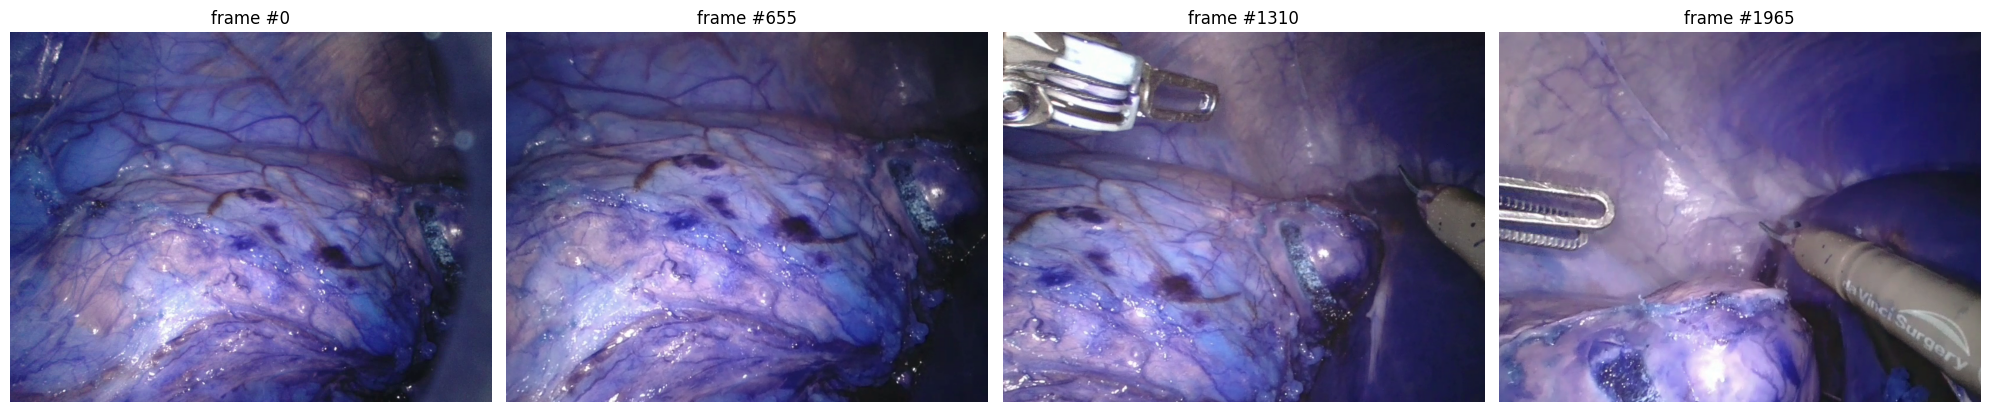

In [5]:
# Quick visualization
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ns = np.linspace(0, len(frames)-1, 4, dtype=int)
for i, n in enumerate(ns):
    ax[i].imshow(frames[n])
    ax[i].set_title(f'frame #{n}')
    ax[i].set_axis_off()
fig.tight_layout()

#### Load data

In [4]:
composed_transforms = transforms.Compose(
    [
        SampleToTensor(),
        RescaleImages((img_height, img_width)),
        MaskOutLuminosity(
            threshold_high=lumen_mask_high_threshold,
            threshold_low=lumen_mask_low_threshold
        ),
        SampleToDevice(device)
    ]
)
dataset = ImageDataset(data_root, transform=composed_transforms)

# Determine frames to process
frames_to_process = list(dataset.images.keys())
if process_subset:
    if start_idx > end_idx:
        frames_to_process = list(
            filter(
                lambda frame_idx: frame_idx in range(
                    end_idx,
                    start_idx,
                    image_subsample
                ),
                frames_to_process
            )
        )
        frames_to_process = frames_to_process[::-1]
    else:
        frames_to_process = list(
            filter(
                lambda frame_idx: frame_idx in range(
                    start_idx,
                    end_idx,
                    image_subsample
                ),
                frames_to_process
            )
        )

# Create SLAM structure (data storage + bundle adjustment)
slam_structure = SLAMStructure(
    name=name,
    output_folder=output_folder,
    BA_sparse_solver=not dense_ba,
    BA_verbose=verbose_ba,
    BA_opt_iters=tracking_ba_iterations
)

print("Number of frames to process: ", len(dataset))

Number of frames to process:  1966


#### Load tracking module and associated components

In [5]:
# Pose guesser component
if pose_guesser == 'last_pose':
    pose_guesser =  PoseGuesserLastPose()
elif pose_guesser == 'constant_velocity':
    pose_guesser =  PoseGuesserConstantVelocity()
else:
    raise ValueError(f'Unknown argument for pose_guesser: {pose_guesser}')

# Depth estimation component
depth_estimator = DepthEstimatorConstant(depth_scale)

# Point sampling component
tracked_points = [
    tracked_point_num_min,
    tracked_point_num_max,
    minimum_new_points
]
if point_sampler == 'uniform':
    point_sampler = PointResamplerUniform(*tracked_points)
elif point_sampler == 'sift':
    point_sampler = PointResamplerSIFT(*tracked_points)    
elif point_sampler == 'orb':
    point_sampler = PointResamplerORB(*tracked_points)    
elif point_sampler == 'r2d2':
    point_sampler = PointResamplerR2D2(*tracked_points)    
elif point_sampler == 'density':
    point_sampler = PointResamplerUniformDensity(*tracked_points)
else:
    raise ValueError(f'Unknown argument for point_sampler: {point_sampler}')

# Point tracking component
cotracker = CoTrackerPredictor(
    checkpoint="../src/OneSLAM/trained_models/cotracker/"+cotracker_model+".pth"
).to(device=device)
cotracker.eval()

# Create tracking module
tracking_module = Tracking(
    depth_estimator,
    point_sampler,
    cotracker,
    device,
    cotracker_window_size=cotracker_window_size
)

#### Run SLAM pipeline

In [ ]:
# Current section and keyframes 
current_section = []
current_keyframes = []

# History of old sections
completed_sections = []

# Cooldowns
orb_keyframe_cooldown = 4
keyframe_cooldown = 0
refframe_cooldown = 0
point_resample_cooldown = 0

# For calculating tracking FPS
# (how long does frame localization take on average)
total_tracking_time = 0
tracking_counter = 0

# For calculating mapping FPS
# (how long does mapping take on average)
total_mapping_time = 0
mapping_counter = 0

completed_sections = 0

# For calculating effective update FPS
# (how many frame updates does the pipeline provide per second)
update_counter = 0
total_update_time = 0

# Main SLAM loop
for frame_idx in tqdm(frames_to_process):
    # Add frame to slam structure
    last_poses = slam_structure.get_previous_poses(10)

    # Special case for first iteration
    if len(slam_structure.poses.keys()) == 0:
        # Retrieve data to add frame and make into keyframe
        image = dataset[frame_idx]['image'].detach().cpu().numpy()
        depth = depth_estimator(
            dataset[frame_idx]['image'],
            dataset[frame_idx]['mask']
        ).squeeze().detach().cpu().numpy()
        intrinsics = dataset[frame_idx]['intrinsics'].detach().cpu().numpy()
        mask = dataset[frame_idx]['mask'].squeeze().detach().cpu().numpy()
        mask[depth < 1e-6] = 0

        # Get new estimate for poses
        pose = pose_guesser(last_poses)

        # Add first frame and make into keyframe
        slam_structure.add_frame(frame_idx, pose, intrinsics)
        slam_structure.make_keyframe(frame_idx, image, depth, mask, fixed=True)
        keyframe_cooldown = keyframe_subsample
    else:
        # Retrieve data to add new frame
        intrinsics = dataset[frame_idx]['intrinsics'].detach().cpu().numpy()
        pose = pose_guesser(last_poses)

        # Add new frame
        slam_structure.add_frame(frame_idx, pose, intrinsics)

    # If localization is enabled and map is initiallized, localize frame
    if completed_sections > 1:
        tracking_start_time = time.time()

        localized_frame = slam_structure.poses[frame_idx][0]

        # Skip localization if disabled, good for test runs
        if not no_localize:
            # Run a minimal point tracking to obtain localization correspondences
            section_to_track = list(
                slam_structure.poses.keys()
            )[-past_frame_size:]
            start_frame = max(0, past_frame_size - len(current_section) - 1)
            if verbose:
                print("Current section: ", current_section)
                print("Tracking start index: ", section_to_track[start_frame])

            tracking_module.process_section(
                section_to_track,
                dataset,
                slam_structure, 
                sample_new_points=False, 
                start_frame=start_frame,
                maximum_track_num=localization_track_num
            )

            # Localize frame
            localized_frame = slam_structure.localize_frame(
                frame_idx, 
                update_pose=update_localized_pose,
                ransac=ransac_localization
            )

   
        # Tracking done and new update available
        current_time = time.time()

        update_counter += 1
        total_update_time += current_time - update_start_time

        tracking_counter += 1
        total_tracking_time += current_time - tracking_start_time

        # Print update
        if verbose:
            print("Current frame: ", localized_frame[:3, 3])
            print("Running section: ", current_section)
            print("Running FPS: ", update_counter/total_update_time)
            if tracking_counter > 0:
                print(
                    "Running Tracking FPS: ",
                    tracking_counter/total_tracking_time
                )
            if mapping_counter > 0:
                print(
                    "Running Mapping FPS: ",
                    mapping_counter/total_mapping_time
                )


        update_start_time = time.time()


    # Add frame to current section
    current_section.append(frame_idx)

    # Check if frame buffer is full.
    if len(current_section) < section_length:
        continue
    
    # New mapping counter starts
    mapping_start_time = time.time()

    # Section full, start MAPing

    # Remove all existing correspondences (likely to be faulty),
    # except for frist frame
    for idx in current_section[1:]:
        assert idx not in slam_structure.keyframes
        slam_structure.pose_point_map[idx] = []

    # Update point resample cooldown
    point_resample_cooldown -= 1

    # Obtain new consistent set of point correspondences
    section_to_track = np.copy(current_section)
    tracking_module.process_section(
        section_to_track,
        dataset,
        slam_structure, 
        sample_new_points=(point_resample_cooldown<=0),
        start_frame=0,
        maximum_track_num=tracked_point_num_max
    )

    # Update point resample cooldown 
    if point_resample_cooldown <=0:
        point_resample_cooldown = point_resample_cooldown

    # Decide to make frames into new keyframes
    new_keyframe_counter = 0
    for idx in current_section[1:]:
        # Keyframe decision

        make_keyframe = False
        
        if keyframe_decision == "subsample":
            keyframe_cooldown -= 1
            if keyframe_cooldown <= 0:
                keyframe_cooldown = keyframe_subsample
                make_keyframe = True

        if keyframe_decision == "orb":
            keyframe_cooldown -= 1
            if keyframe_cooldown <= 0:
                # Check if last keyframe was old
                make_keyframe = True
            else:
                last_keyframe = slam_structure.keyframes[-1]
                last_pose_points = slam_structure.pose_point_map[last_keyframe]
                last_point_ids = set()
                for (point_id, point_2d) in last_pose_points:
                    last_point_ids.add(point_id)

                current_pose_points = slam_structure.pose_point_map[idx]

                tracked_point_ids = set()
                for (point_id, point_2d) in current_pose_points:
                    if point_id in last_point_ids:
                        tracked_point_ids.add(point_id)
                
                if len(tracked_point_ids)/len(last_point_ids) < 0.8:
                    make_keyframe = True

            if make_keyframe:
                keyframe_cooldown = orb_keyframe_cooldown

        if not make_keyframe:
            continue

        # Frame was choosen to be a keyframe

        image = dataset[idx]['image'].detach().cpu().numpy()
        depth = depth_estimator(
            dataset[idx]['image'],
            dataset[idx]['mask']
        ).squeeze().detach().cpu().numpy()
        mask = dataset[idx]['mask'].squeeze().detach().cpu().numpy()
        mask[depth < 1e-6] = 0

        slam_structure.make_keyframe(idx, image, depth, mask, fixed=False)
        new_keyframe_counter += 1

    # If there are new keyframes, run local BA
    if new_keyframe_counter > 0:
        for idx in slam_structure.keyframes[
            :-(local_ba_size+new_keyframe_counter)
        ]:
            slam_structure.BA.fix_pose(idx, fixed=True)
        for idx in slam_structure.keyframes[
            -(local_ba_size+new_keyframe_counter):
        ]:
            slam_structure.BA.fix_pose(idx, fixed=False)
        slam_structure.BA.fix_pose(slam_structure.keyframes[0], fixed=True)
            
        slam_structure.run_ba(opt_iters=tracking_ba_iterations)

    # Mapping done
    current_time = time.time()
    mapping_counter += 1
    total_mapping_time += current_time - mapping_start_time

    # Update section
    current_section = current_section[-1:]
    completed_sections += 1

    if completed_sections == 2:
        # This was the map initialization, start update counter
        update_start_time = time.time()
        if verbose:
            print("Map initizalized.")

# Filter outliers in reconstruction
# NOTE: ONLY FILTER AFTER EVERYTHING IS OPTIMIZED, DOES NOT UPDATE 
# NOTE: Possibly filters the entire sparse reconstruction, resulting in an error when trying to save data.
#       Disable to allow evaluating the pose predictions in these cases.
slam_structure.filter(min_view_num=2, reprojection_error_threshold=10)

slam_structure.save_visualizations()

# Save data and visualizations
slam_structure.save_data(
    dataset, 
    update_fps=update_counter/total_update_time,
    tracking_fps=tracking_counter/total_tracking_time,
    mapping_fps=mapping_counter/total_mapping_time
)

  0%|          | 0/1966 [00:00<?, ?it/s]

Done! You can now move to the `plotting.ipynb` notebook for plotting these results.